In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from art import tprint

In [ ]:
df = pd.read_excel("ecology.xlsx")
df.head(3)

,id,a4a,a6a,a2,a0,b1,b5,b7a,d1a1x,g1a,...,BMGc23i,BMGc23j,BMGc24,BMGc25,BMGc27,BMGd6,BMGd7,BMGe1,BMGe2,BMGe2u
0,22,Готовые Металлические Изделия,Малый,Центральный Федеральный округ,Производство,Акционерная компания с неторгуемыми акциями ил...,2007,Нет,Производство Готовых Строительных Металлически...,0,...,Да,Нет,Модернизация машин и оборудования,Да,NaN,Нет,Нет,100000,20000,Литры
1,29,Машины и оборудование,Крупный,Центральный Федеральный округ,Производство,Акционерная компания с неторгуемыми акциями ил...,2002,Нет,Производство Насосов И Компрессоров,0,...,Нет,Нет,Модернизация машин и оборудования,Нет,Не является приоритетом по сравнению с другими...,Нет,Нет,160000,18500,Литры
2,34,Другое Производство,Средний,Центральный Федеральный округ,Производство,Акционерная компания с неторгуемыми акциями ил...,2005,Нет,"Производство Алюминиевых И Медных Проводов, Си...",100,...,Да,Не знаю,NaN,Нет,Нехватка финансовых ресурсов,Нет,Нет,Не знаю,Не знаю,NaN


In [ ]:
df.shape

(1323, 48)

Эта фанка вернёт названия столбцов в которых всего несколько строковых значений, а остальные - чиселки, т.е. есть что чистить

In [ ]:
def get_dict_of_cols(df: pd.DataFrame, n=2, exclude=['id']):
    """
    returns a dict like: {column: [str_value, str_value]} where the str_value is one of the few string values in the column
    df is your main pandas dataframe
    n is the maximum allowed number of string values per column
    len(return[column]) <= n
    """
    result = {}
    columns_in_df = df.columns
    for column in columns_in_df:
        if column in exclude:
            continue
        str_count, strs, digit_count = 0, [], 0
        values = df[column].value_counts().keys()
        for val in values:
            if str(val).isdigit():
                digit_count += 1
            else:
                str_count += 1
                strs.append(val)
            if str_count > n:
                continue
        if digit_count == 0:
            continue
        result[column] = strs
    return result

Эта херь будет выводить графики распределения для данных столбцов

In [ ]:
def print_distr(df: pd.DataFrame, cols: dict, figsize: tuple[int, int] = (30, 30), bins: int = 100) -> tuple[bool, str]:
    try:
        _, axes = plt.subplots((len(cols.keys()) // 2) + (1 if len(cols.keys()) % 2 > 0 else 0), 2, figsize=figsize)  # не читайте, не надо, это просто работает, ок?
        i, j, max_i = 0, 0, (len(cols.keys()) // 2) + (1 if len(cols.keys()) % 2 > 0 else 0)
        for col in cols.keys():
            exceptions = cols[col]
            col_of_nums = df[col].apply(lambda x: (-1000 if (x in exceptions or x != x) else float(x)))  # x != x only when x is NaN
            axes[i, j].hist(col_of_nums, bins=bins)
            axes[i, j].set_xlabel(f'Значение переменной {col}')
            axes[i, j].set_ylabel('Частота')
            axes[i, j].set_title(f'График распределения переменной {col}')
            # axes[i, j].set_xticks(range())
            # axes[i, j].set_xlim(min(-1000, col_of_nums.min()), col_of_nums.max())
            # axes[i, j].set_ylim(0, 1500)
            i += 1
            if i == max_i:
                j += 1
                i = 0
        plt.tight_layout()
        plt.show()
    except Exception as ex:
        return False, str(ex)
    return True, ""

Проверка элемента на явление выбросом (ебать сказанул)

In [ ]:
def is_el_ok(elem: str, exceps: list[str], Q3: int, Q1: int, value_for_exceptions=True, value_for_nan=True):
    if elem in exceps:
        return value_for_exceptions
    elem = float(elem)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    if lower_bound <= elem <= upper_bound:
        return True
    if elem != elem:
        return value_for_nan
    return False

А эта объединяет всё вместе и чистит датасет от выбросов

In [ ]:
def remove_emis(df: pd.DataFrame, n:int=2, logging: bool = False):
    cols = get_dict_of_cols(df=df, n=n, exclude=['id', 'b5', 'g1a', 'j30_environment_pos'])
    tprint("Cols:")
    print()
    print(*cols, sep=' | ')
    tprint("============================")
    clear_df = df.copy(deep=True)
    deleted = {}
    """
    deleted = {
        column: {
            Q1: Q1,
            Q3: Q3,
            count: (count of deleted elements)
            deleted: []
        },
        ...
    }
    """
    for col in cols.keys():
        exceptions = cols[col]
        Q3 = clear_df[clear_df[col].apply(lambda x: x not in exceptions)][col].astype(float).quantile(0.75)
        Q1 = clear_df[clear_df[col].apply(lambda x: x not in exceptions)][col].astype(float).quantile(0.25)
        values = clear_df[col].apply(lambda x: is_el_ok(elem=str(x), exceps=exceptions, Q3=Q3, Q1=Q1))
        if logging:
            deleted[col] = {}
            deleted[col]["Q1"], deleted[col]["Q3"] = Q1, Q3
            deleted[col]["count"] = values.value_counts().values[1] if len(values.value_counts()) > 1 else 0
            deleted[col]['deleted'] = list(clear_df[~values][col].values)
            print(f"column: {col} => deleted: {values.value_counts().values[1] if len(values.value_counts().values) > 1 else 0}")
        clear_df = clear_df[values]
    tprint("WAS:")
    print_distr(df, cols, (10, 13))
    tprint("============================")
    tprint("BECAME:")
    print_distr(clear_df, cols, (10, 13))
    if logging:
        return clear_df, deleted
    return clear_df, {}


  ____         _         
 / ___|  ___  | | ___  _ 
| |     / _ \ | |/ __|(_)
| |___ | (_) || |\__ \ _ 
 \____| \___/ |_||___/(_)
                         


n2a | n2e | n2b | n2f | n2i | n2p | BMGe1 | BMGe2
                                                                                                                                                                                                    
 _____  _____  _____  _____  _____  _____  _____  _____  _____  _____  _____  _____  _____  _____  _____  _____  _____  _____  _____  _____  _____  _____  _____  _____  _____  _____  _____  _____ 
|_____||_____||_____||_____||_____||_____||_____||_____||_____||_____||_____||_____||_____||_____||_____||_____||_____||_____||_____||_____||_____||_____||_____||_____||_____||_____||_____||_____|
|_____||_____||_____||_____||_____||_____||_____||_____||_____||_____||_____||_____||_____||_____||_____||_____||_____||_____||_____||_____||_____||_____||_____||_____||_____||_____||_____||_____|
    

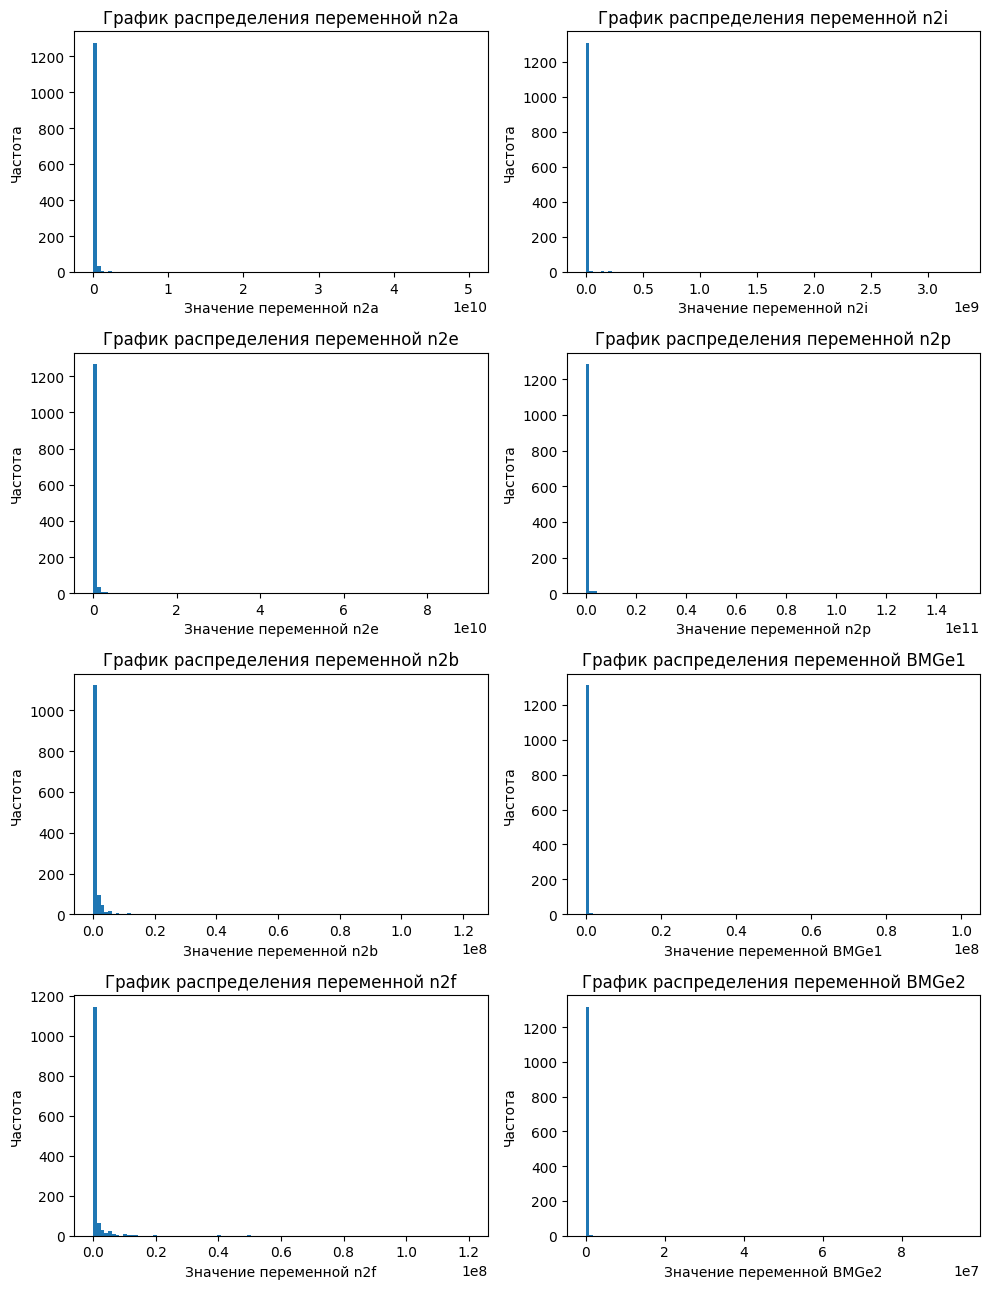

                                                                                                                                                                                                    
 _____  _____  _____  _____  _____  _____  _____  _____  _____  _____  _____  _____  _____  _____  _____  _____  _____  _____  _____  _____  _____  _____  _____  _____  _____  _____  _____  _____ 
|_____||_____||_____||_____||_____||_____||_____||_____||_____||_____||_____||_____||_____||_____||_____||_____||_____||_____||_____||_____||_____||_____||_____||_____||_____||_____||_____||_____|
|_____||_____||_____||_____||_____||_____||_____||_____||_____||_____||_____||_____||_____||_____||_____||_____||_____||_____||_____||_____||_____||_____||_____||_____||_____||_____||_____||_____|
                                                                                                                                                                                                    
               

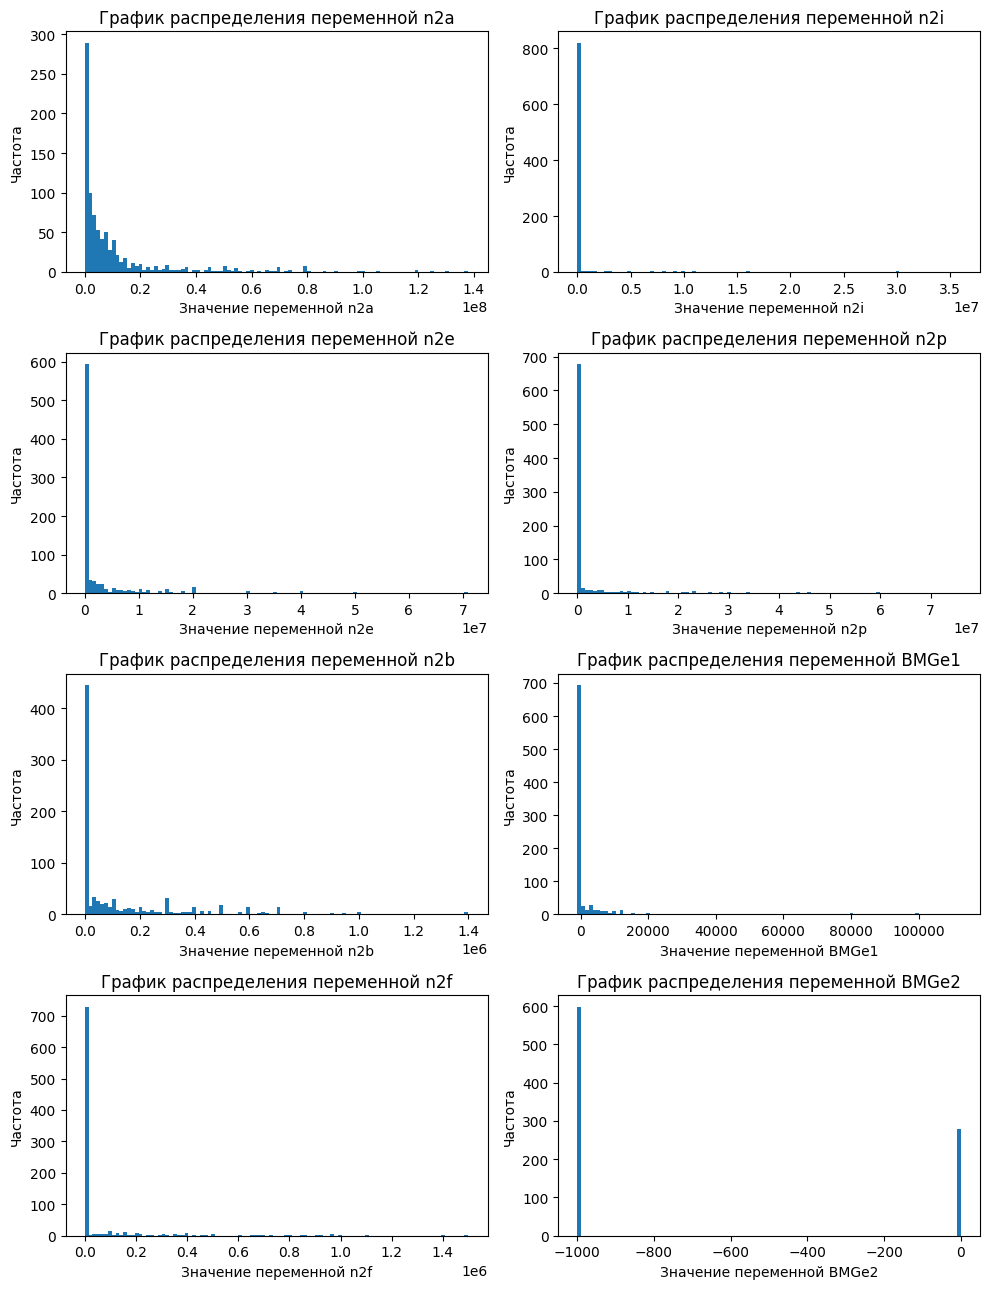

In [ ]:
clear_df, deleted_elements = remove_emis(df=df, logging=True)

In [ ]:
deleted_elements

{'n2a': {'Q1': 4200000.0,
  'Q3': 58240000.0,
  'count': 154,
  'deleted': ['150000000',
   '150000000',
   '160000000',
   '270000000',
   '240000000',
   '150000000',
   '200400000',
   '400000000',
   '900000000',
   '3000000000',
   '180000000',
   '200000000',
   '950000000',
   '155000000',
   '185000000',
   '200000000',
   '270000000',
   '190000000',
   '240600000',
   '190000000',
   '460000000',
   '1000000000',
   '188000000',
   '760000000',
   '480000000',
   '396000000',
   '250000000',
   '4213205000',
   '2000000000',
   '155000000',
   '164000000',
   '150000000',
   '480000000',
   '170000000',
   '248000000',
   '395000000',
   '700000000',
   '200000000',
   '200000000',
   '150000000',
   '185000000',
   '480000000',
   '185000000',
   '714000000',
   '250000000',
   '412000000',
   '400000000',
   '200000000',
   '250000000',
   '145000000',
   '450000000',
   '900000000',
   '180000000',
   '500000000',
   '460790000',
   '200000000',
   '350000000',
   '4700000

In [ ]:
clear_df.shape

(878, 48)

хуяссе там выбросов .-.

In [ ]:
clear_df.to_excel("clear_ecology.xlsx")